In [1]:
import pandas as pd
import swifter
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier



from sklearn.ensemble import RandomForestClassifier


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 5]


In [14]:
df = pd.read_excel("./Data/M&A dataset v2.xlsx")
df['Pre-deal target EBIT\nth USD Last avail. yr'] = (df['Pre-deal target EBIT\nth USD Last avail. yr']
    .str.replace(' ', '')  # Remove spaces
    .replace('n.a.', np.nan))
df.dropna(inplace=True)
df.drop(columns={'Column1'}, inplace=True)
df['Deal Number'] = df['Deal Number'].astype(str)

numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])
df['Last deal status date'] = pd.to_datetime(df['Last deal status date'], unit='D', origin='1899-12-30')
df['Deal status'] = df['Deal status'].apply(lambda x: 1 if x == 'Completed' else 0)
# df['Target CSH - Type'] = df['Target CSH - Type'].apply(lambda x: 1 if x == 'Corporate' else 0)
df['Pre-deal target EBIT\nth USD Last avail. yr'] = df['Pre-deal target EBIT\nth USD Last avail. yr'].astype(float)
df['Target CSH - Type'] = df['Target CSH - Type'].apply(lambda x: 1 if 'Corporate' in str(x) else 0)
df['Sector similarity'] = df['Sector similarity'].apply(lambda x: 1 if x == True else 0)

df = pd.concat([df, pd.get_dummies(df['Deal method of payment'], prefix='method').astype(int)], axis=1)


(np.float64(-1.0999998249305638),
 np.float64(1.0999999916633603),
 np.float64(-1.099993328758413),
 np.float64(1.0999988575973372))

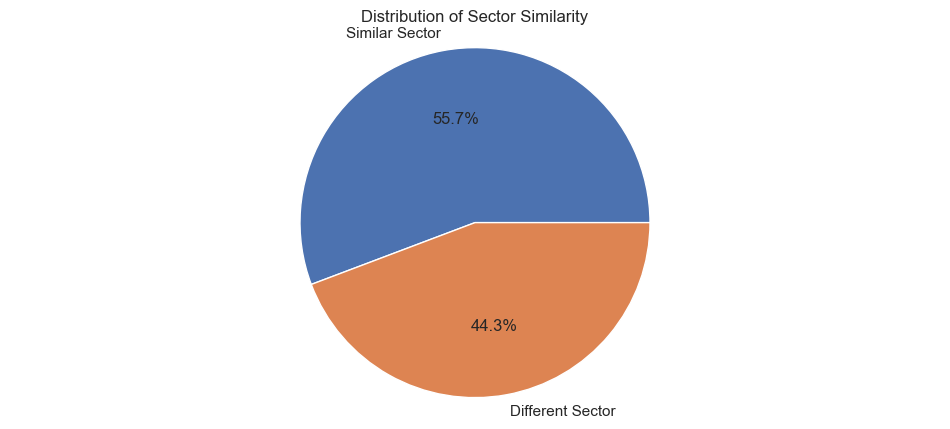

In [15]:
# Create pie chart of sector similarity distribution
plt.figure(figsize=(12, 5))
labels = ['Similar Sector', 'Different Sector'] 
sizes = df['Sector similarity'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Sector Similarity')
plt.axis('equal')


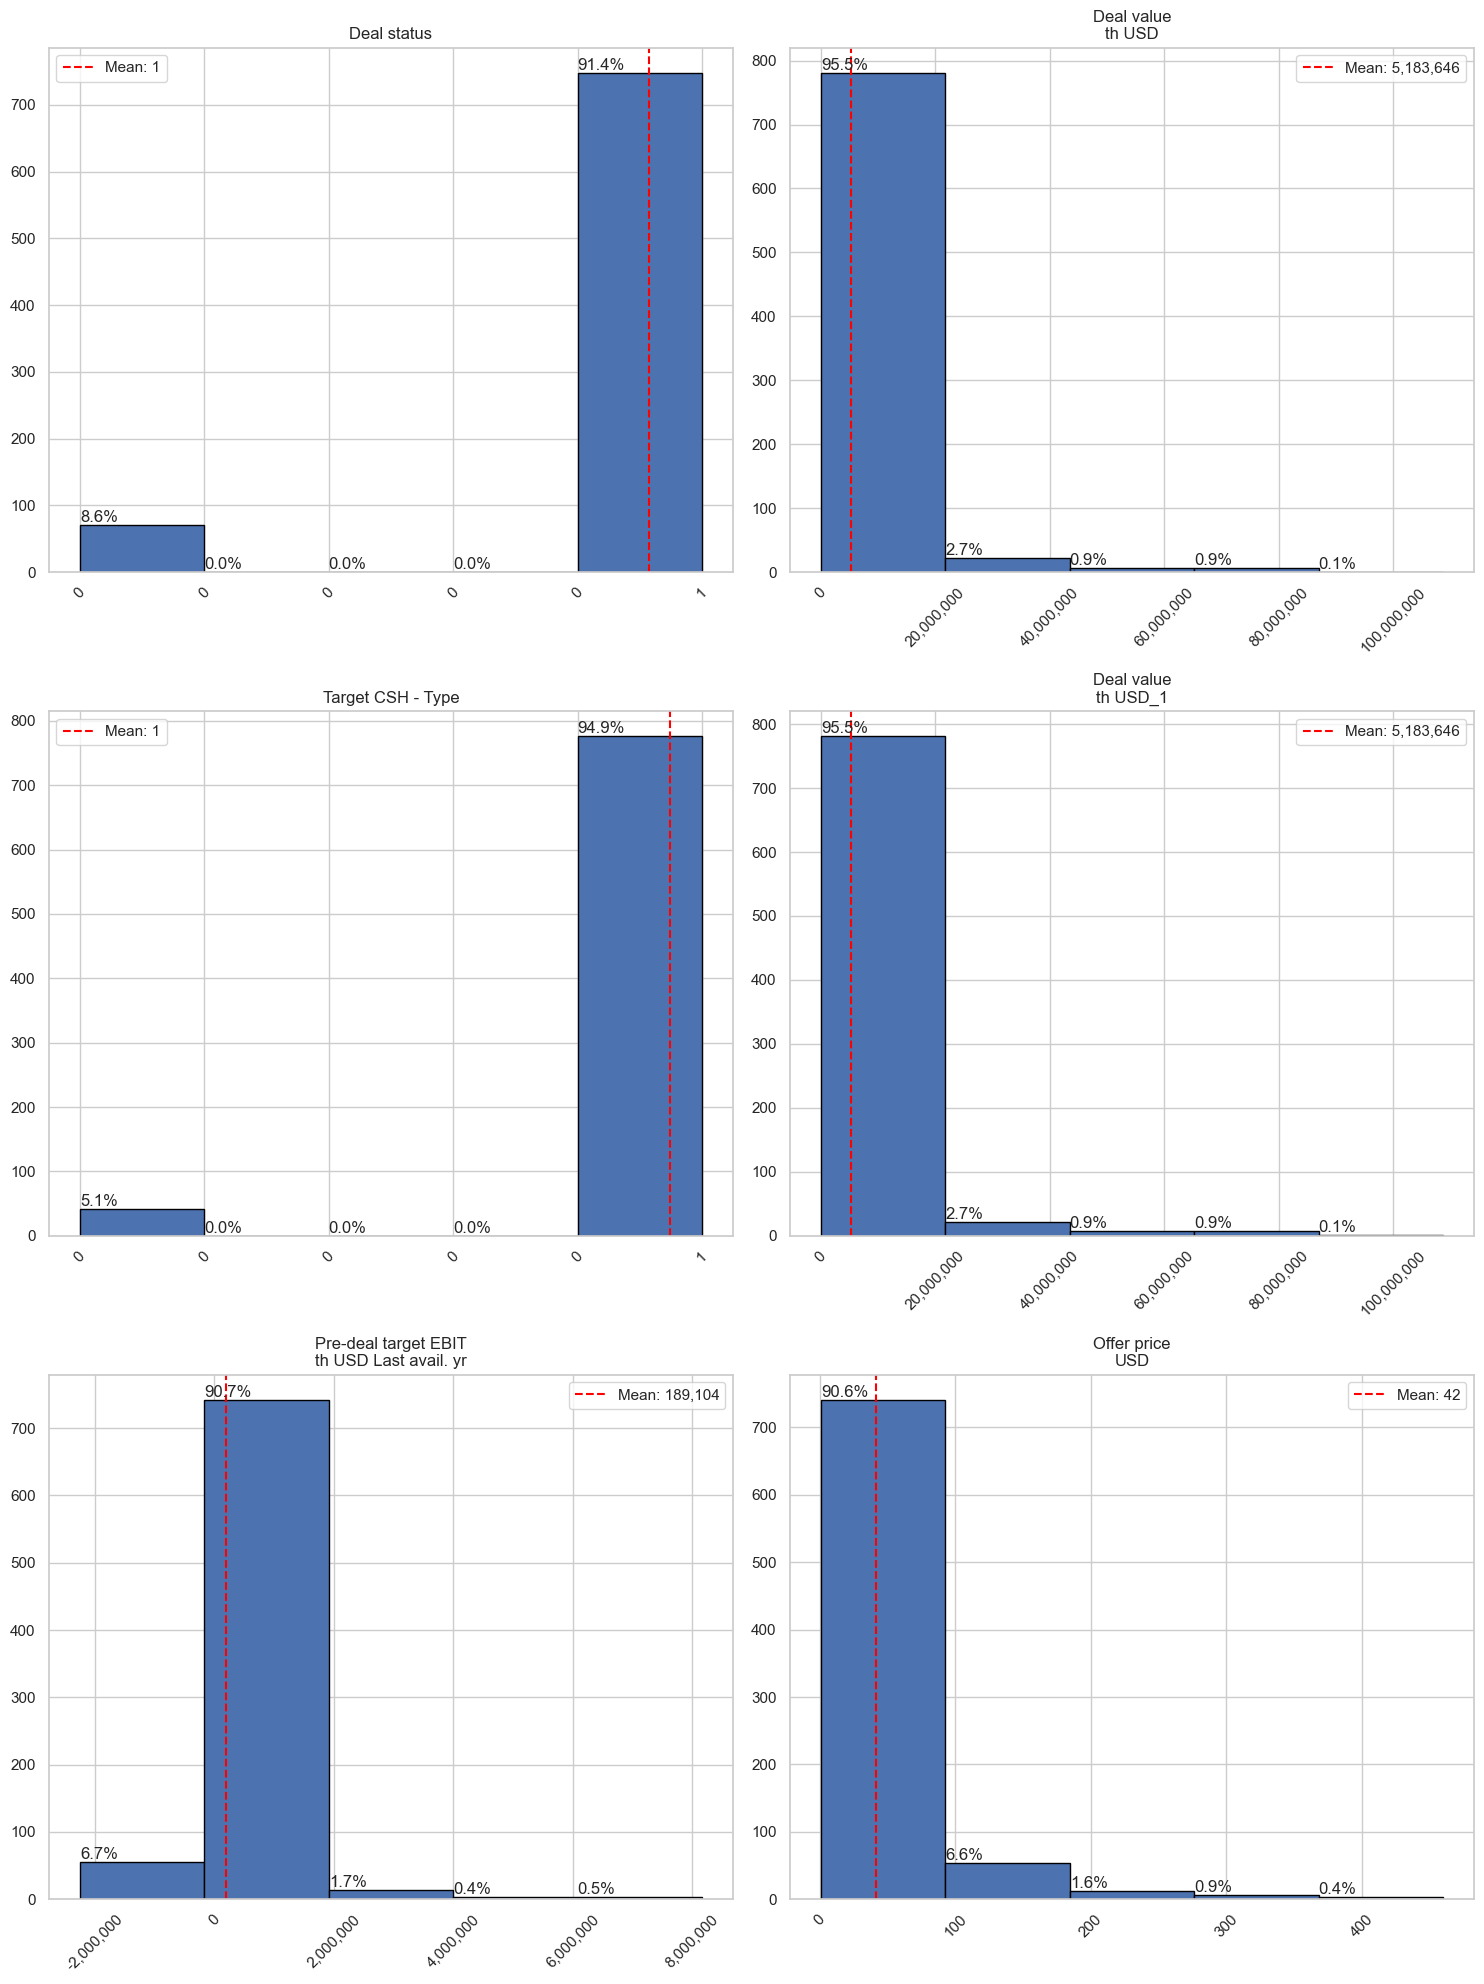

In [3]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()


for idx, col in enumerate(df[numeric_selector].columns):
    if idx < len(axes):
        # Create 3 bins for clear categorization
        data = df[col]
        counts, bins, _ = axes[idx].hist(data, bins=5, edgecolor='black')
        
        # Add percentage labels on top of each bar
        total = len(data)
        for i in range(len(counts)):
            percentage = (counts[i]/total) * 100
            axes[idx].text(bins[i], counts[i], f'{percentage:.1f}%', 
                         ha='left', va='bottom')
        
        mean_val = data.mean()
        axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:,.0f}')
        axes[idx].legend()
        axes[idx].set_title(col)
        axes[idx].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()

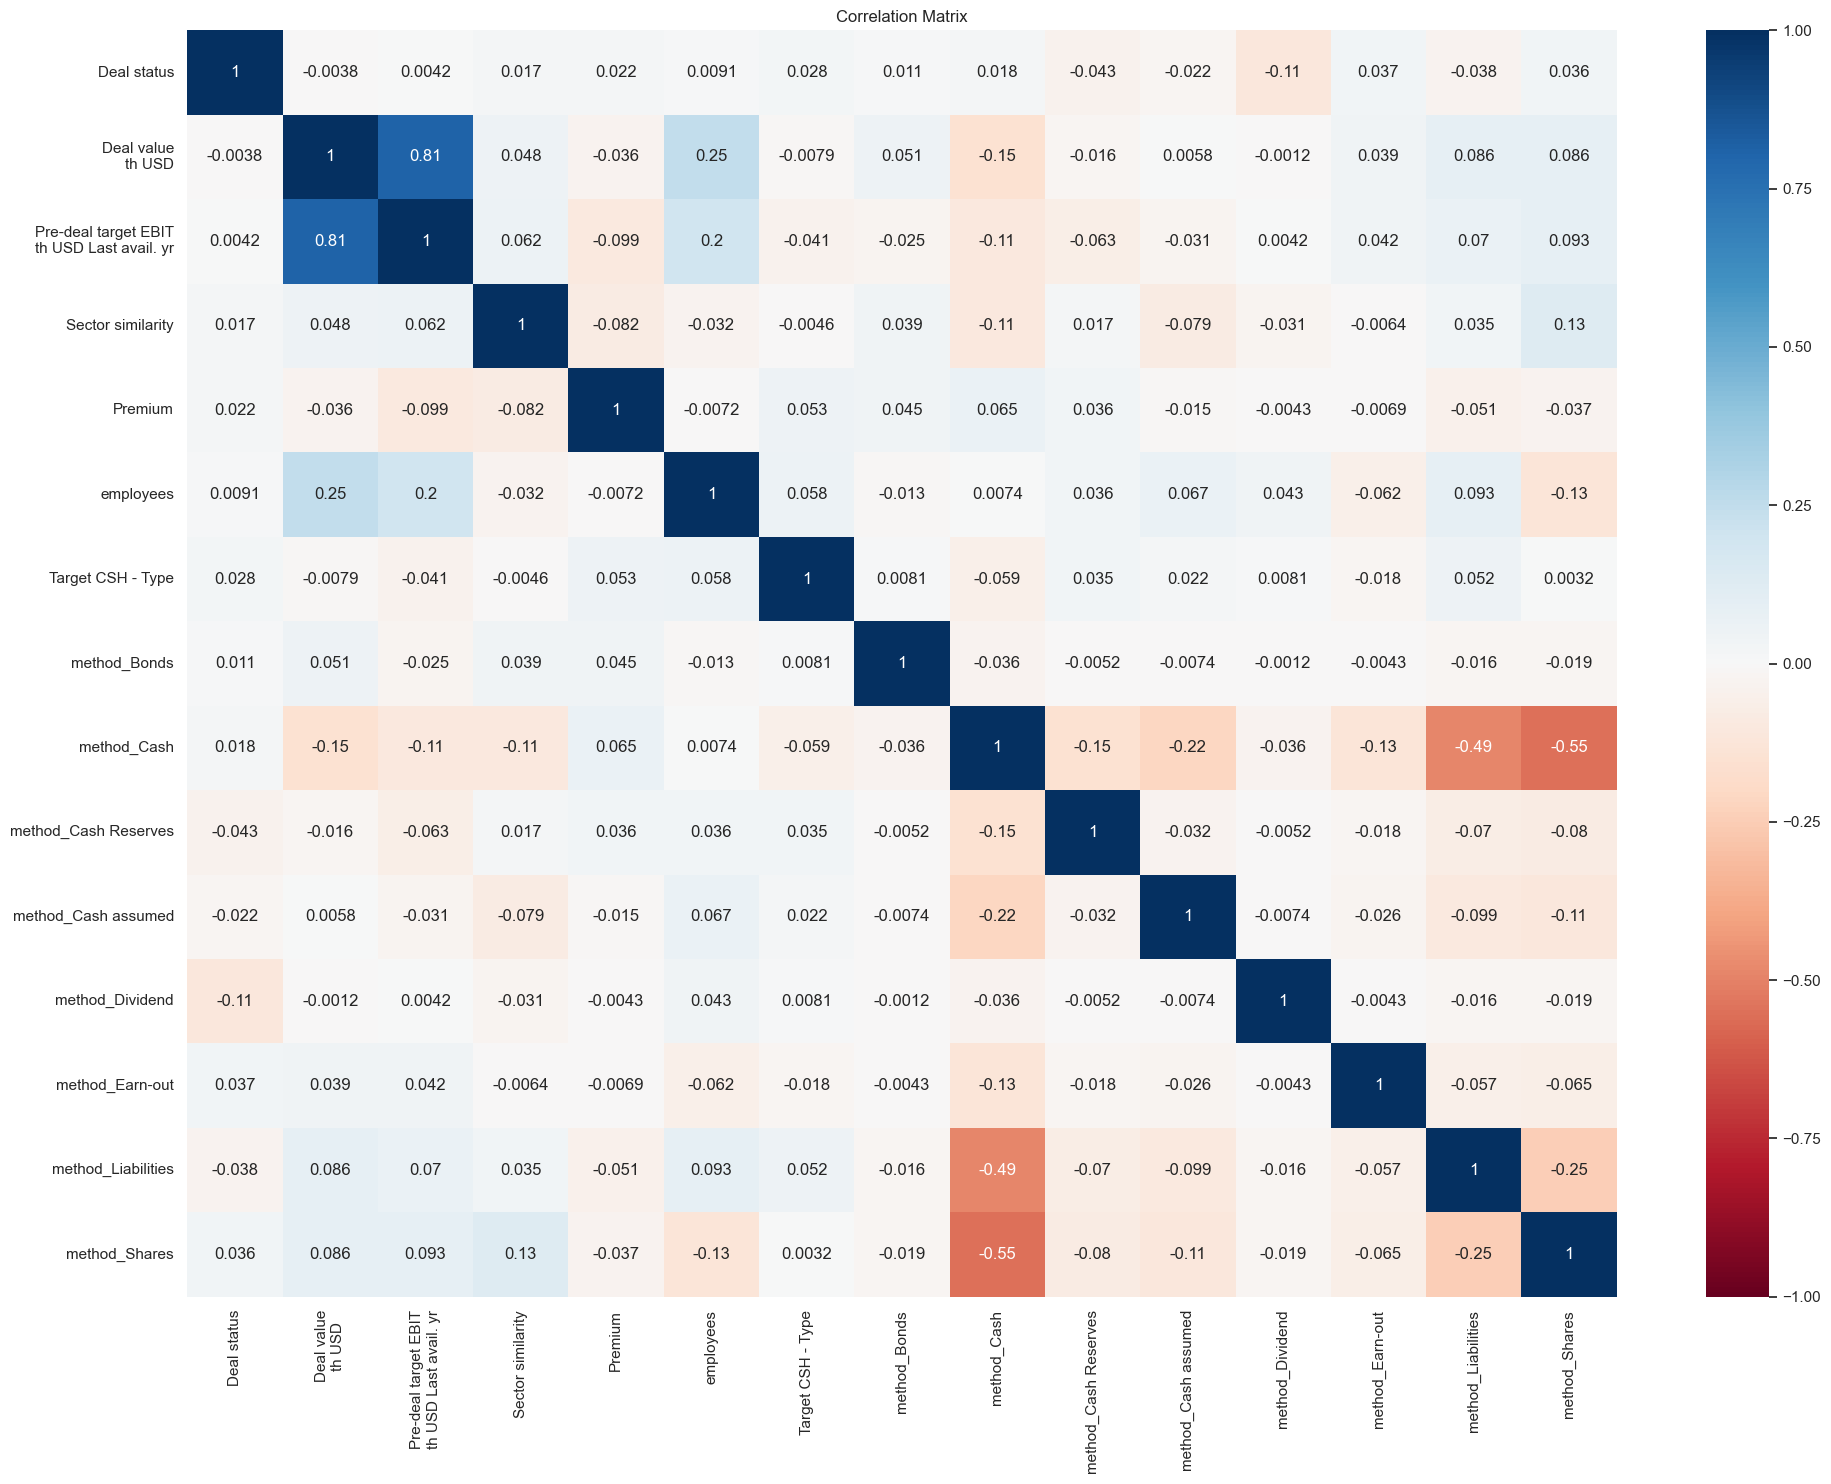

In [16]:
cols = [ 'Deal status', 'Deal value\nth USD', 
        'Pre-deal target EBIT\nth USD Last avail. yr','Sector similarity',
        'Premium', 'employees', 'Target CSH - Type', 'method_Bonds', 'method_Cash', 'method_Cash Reserves',
       'method_Cash assumed', 'method_Dividend', 'method_Earn-out',
       'method_Liabilities', 'method_Shares']

# Calculate correlation matrix and visualize with seaborn
correlation_matrix = df[cols].corr().round(6)
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.tight_layout()


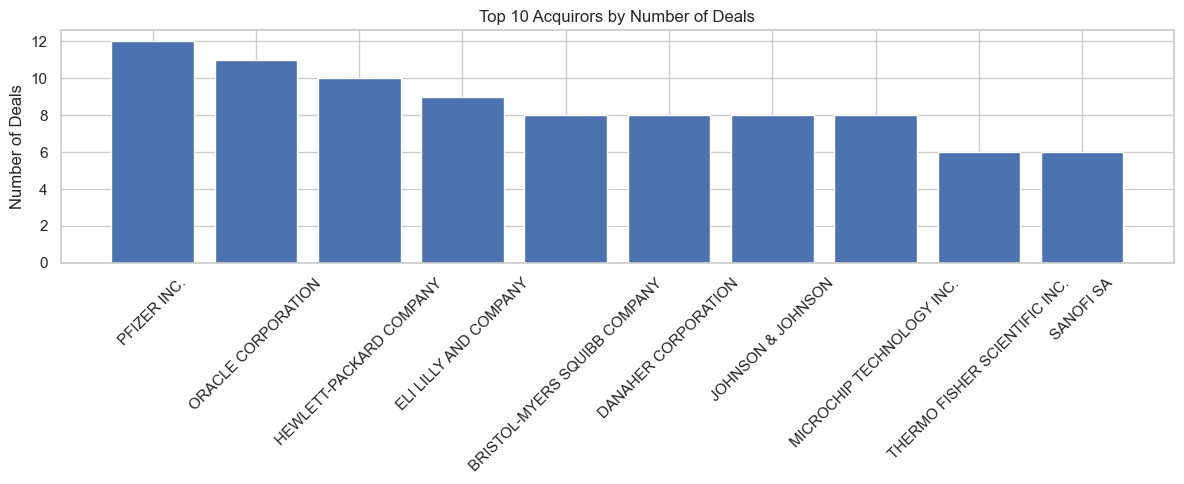

In [5]:
# Get top 10 acquirors and their deal counts
acquiror_deals = df.groupby('Acquiror name')['Deal Number'].count().sort_values(ascending=False)
top_10 = acquiror_deals.head(10)

plt.figure(figsize=(12, 5))
plt.bar(range(len(top_10)), top_10.values)
plt.xticks(range(len(top_10)), top_10.index, rotation=45)
plt.title('Top 10 Acquirors by Number of Deals')
plt.ylabel('Number of Deals')
plt.tight_layout()

In [17]:
df_model = df[cols]


In [19]:
# Separate features (X) and target variable (y)
X = df_model.drop('Deal status', axis=1)
y = df_model['Deal status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Create and fit the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions and print performance metrics
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print feature coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print("\nFeature Coefficients:")
coef_df

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.91      1.00      0.95       224

    accuracy                           0.91       246
   macro avg       0.46      0.50      0.48       246
weighted avg       0.83      0.91      0.87       246


Feature Coefficients:


/Users/nikitasfilosofof/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nikitasfilosofof/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nikitasfilosofof/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

,Feature,Coefficient
5,Target CSH - Type,8.550703e-01
7,method_Cash,5.023865e-01
3,Premium,4.714225e-01
2,Sector similarity,3.818116e-01
13,method_Shares,2.741986e-01
12,method_Liabilities,8.768549e-02
11,method_Earn-out,3.643094e-02
9,method_Cash assumed,2.345904e-02
8,method_Cash Reserves,5.652209e-03
6,method_Bonds,2.182564e-04


Test Accuracy: 0.9065


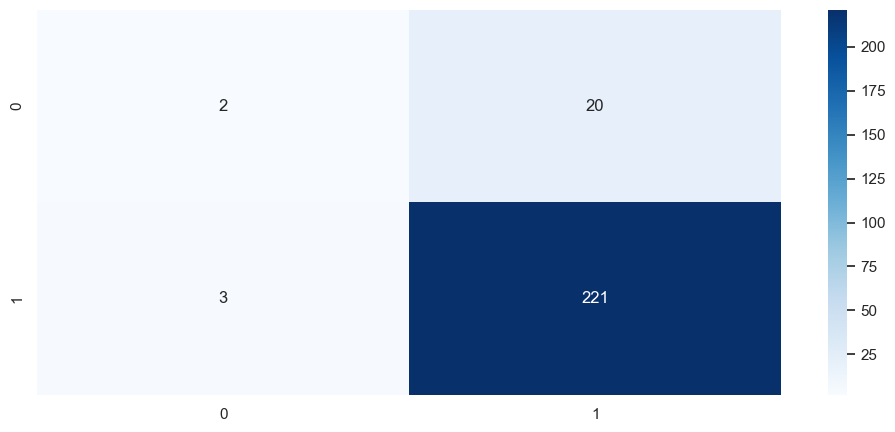

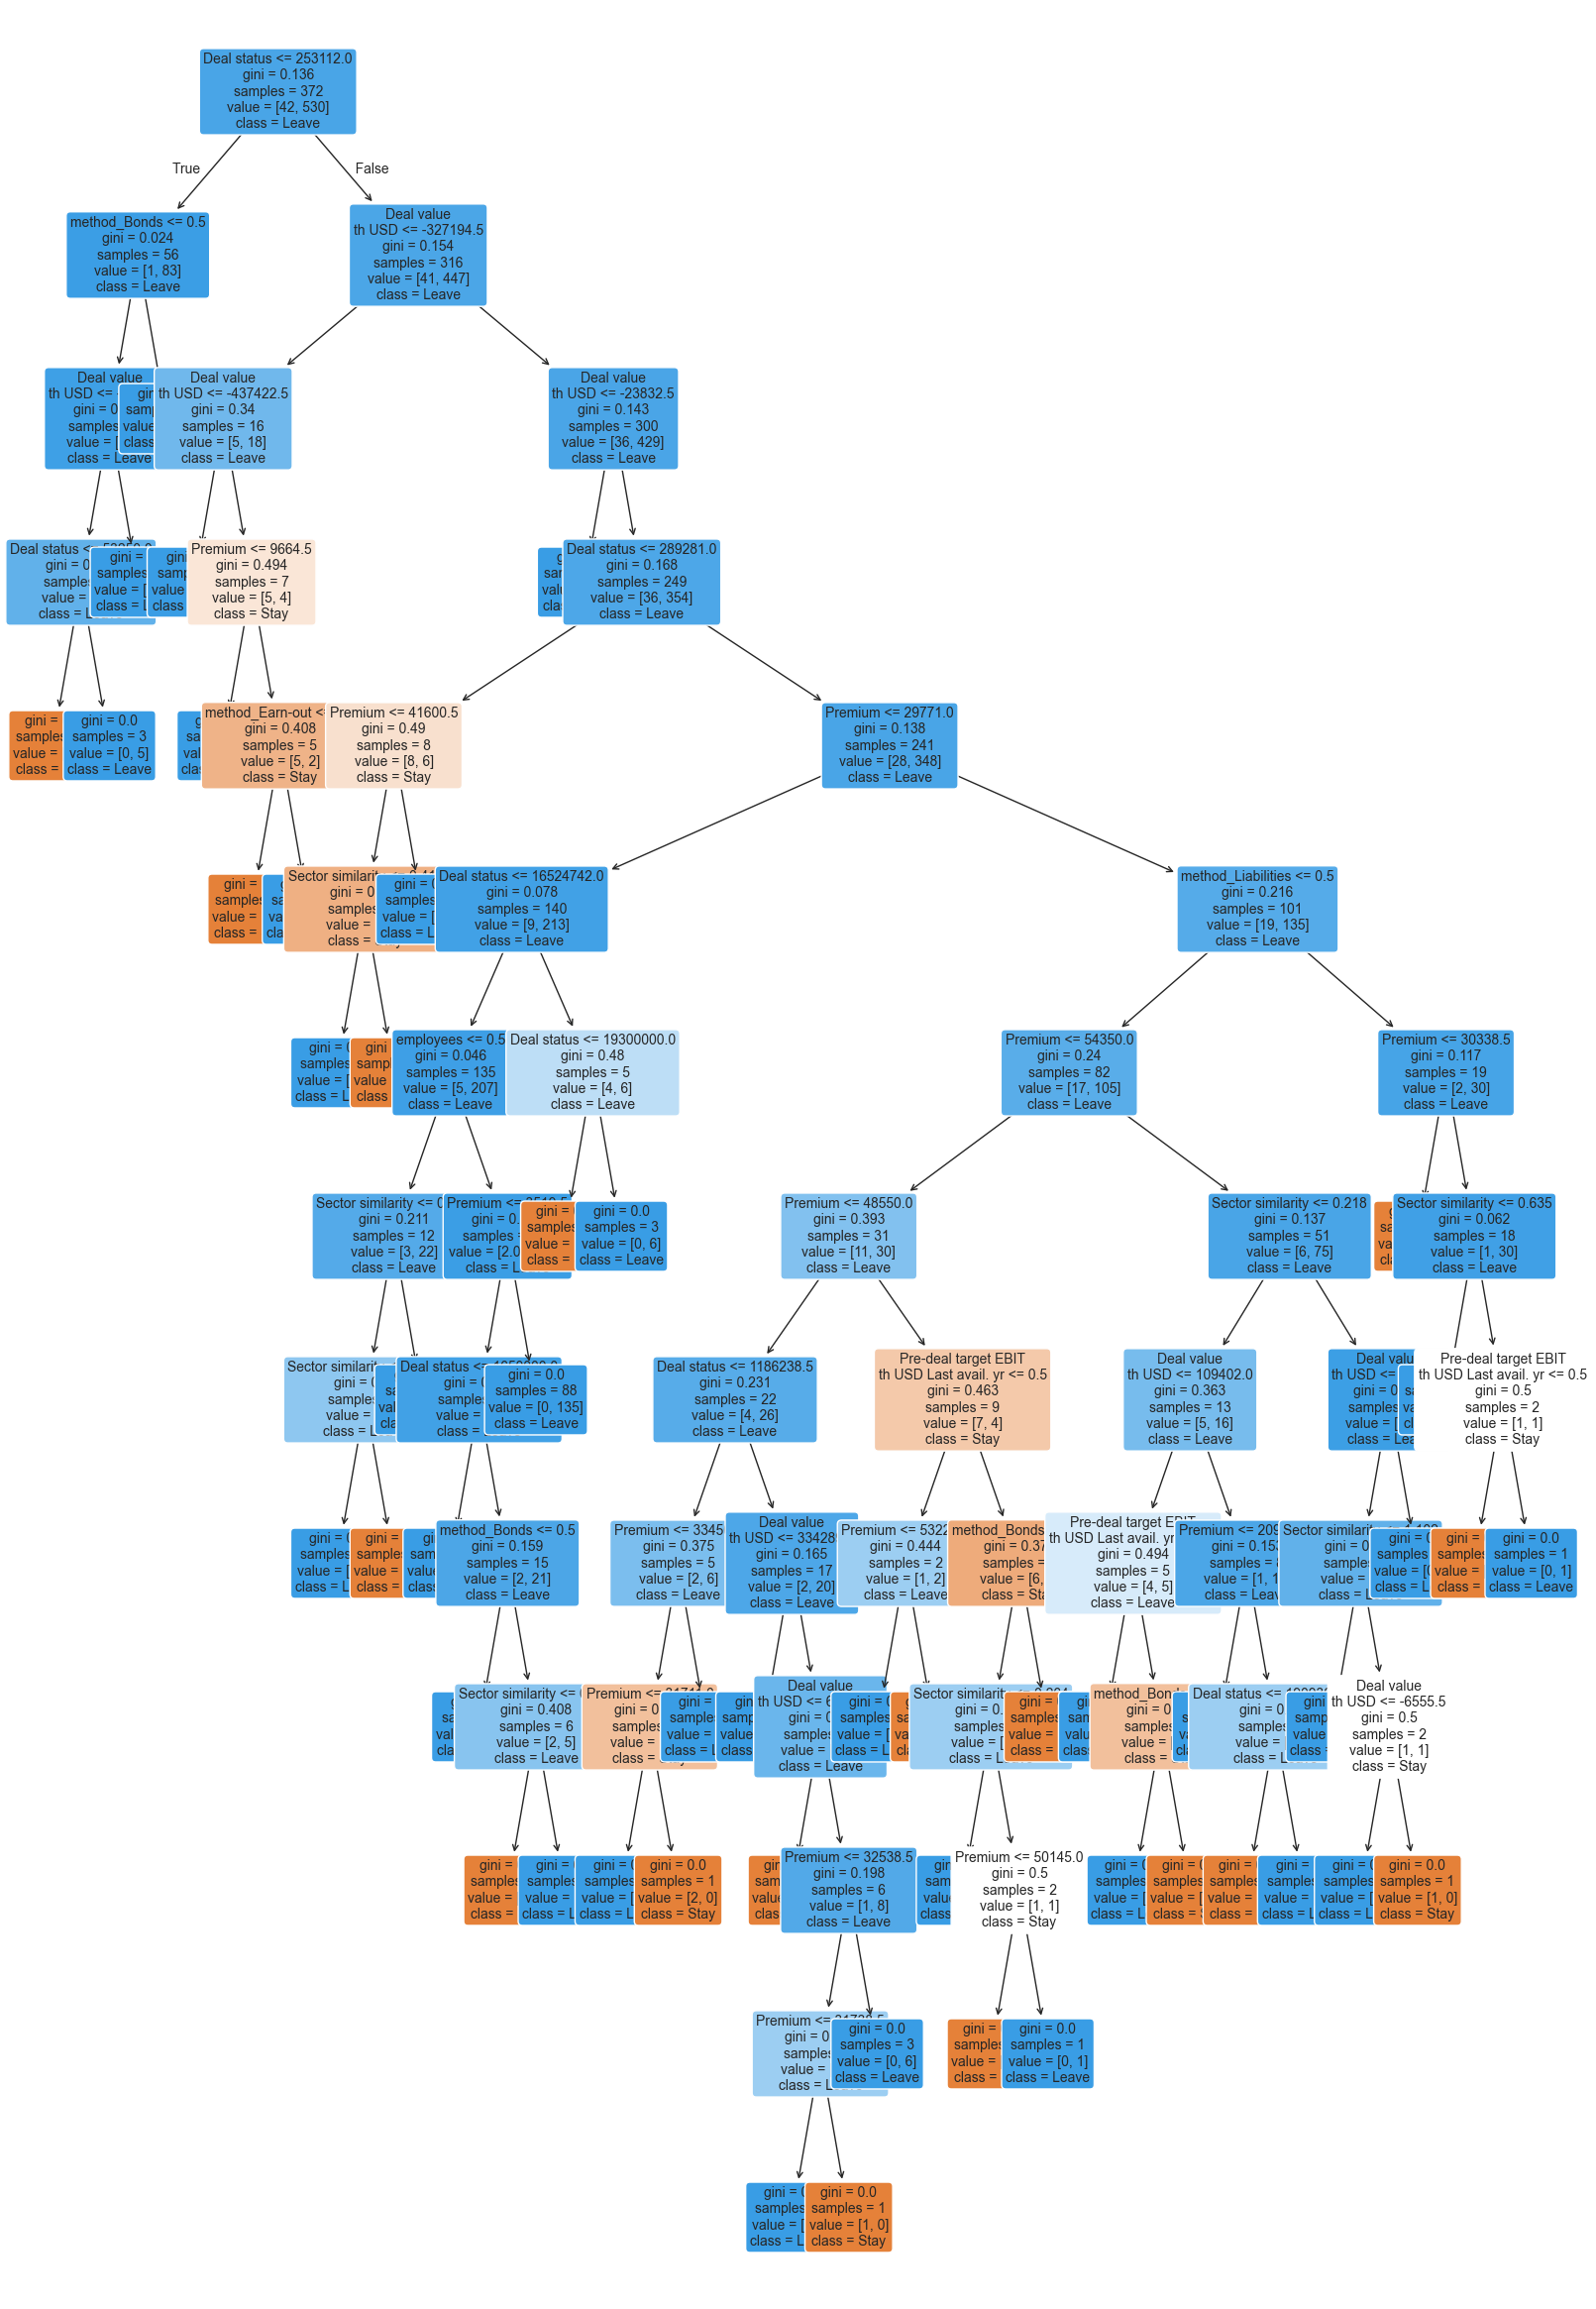

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit and evaluate
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix
y_test_pred = model.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.show()

plt.figure(figsize=(20,30))
plot_tree(model[-1],
          feature_names=cols,  # Use feature_names here
          class_names=['Stay', 'Leave'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.91      1.00      0.95       224

    accuracy                           0.91       246
   macro avg       0.46      0.50      0.48       246
weighted avg       0.83      0.91      0.87       246



/Users/nikitasfilosofof/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nikitasfilosofof/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nikitasfilosofof/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

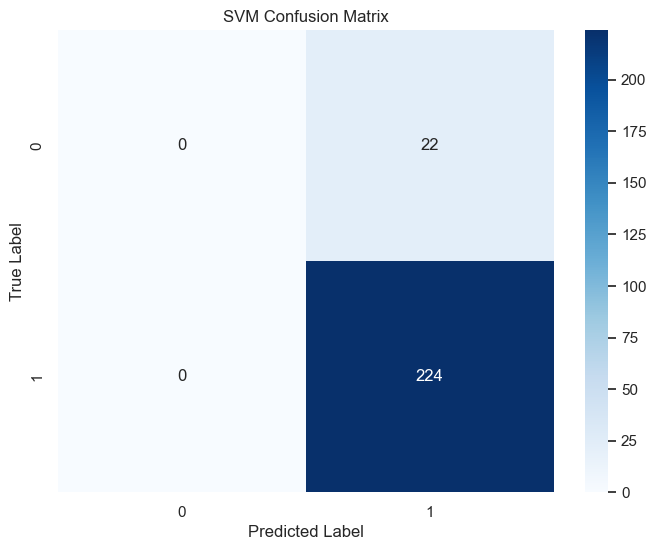

In [21]:
# Create and fit SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions and print performance metrics
y_pred = svm_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.91      0.98      0.94       224

    accuracy                           0.89       246
   macro avg       0.45      0.49      0.47       246
weighted avg       0.83      0.89      0.86       246


Feature Coefficients:


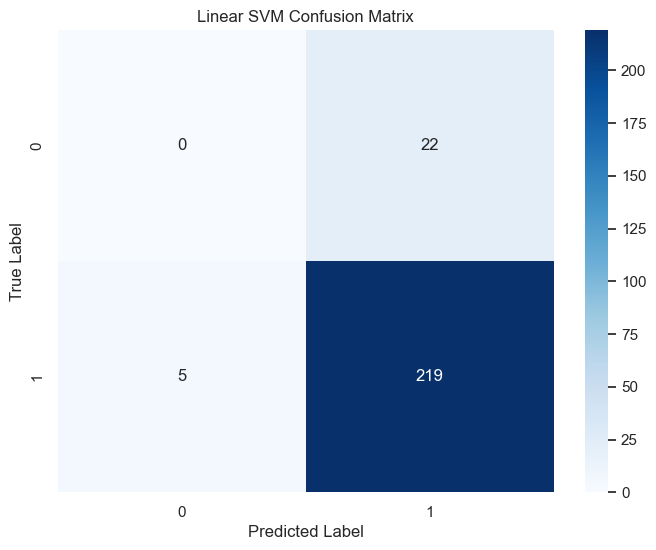

,Feature,Coefficient
3,employees,5.143826e-06
0,Deal value\nth USD,5.383921e-08
4,Target CSH - Type,4.011410e-10
6,method_Cash,2.428059e-10
2,Premium,2.217173e-10
12,method_Shares,1.092798e-10
11,method_Liabilities,4.796638e-11
8,method_Cash assumed,1.484049e-11
10,method_Earn-out,1.331357e-11
7,method_Cash Reserves,4.151021e-12


In [10]:
# Create and fit LinearSVC model
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions and print performance metrics
y_pred = svm_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': svm_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print("\nFeature Coefficients:")


# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Linear SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

coef_df

In [22]:
df_model.to_excel('model_data.xlsx')